In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt

In [2]:
import tenpy
import tenpy.linalg.np_conserved as npc
from tenpy.algorithms import dmrg
from tenpy.networks.mps import MPS

In [3]:
from tenpy.networks.site import SpinSite, SpinHalfSite
from tenpy.models.lattice import Chain
from tenpy.models.model import CouplingModel, NearestNeighborModel, MPOModel

In [4]:
class ClusterIsing(CouplingModel):
    def __init__(self, model_params):
        # Read out/set default parameters
        name = "Cluster Ising model"
        L = model_params.get('L', 5)
        B = model_params.get('B', 0)
        bc_MPS = model_params.get('bc_MPS', 'finite')
        
        # sites
        site = SpinHalfSite(conserve=None)

        # lattice
        bc = 'open'
        lat = Chain(L, site, bc=bc, bc_MPS=bc_MPS)

        # initialize CouplingModel
        CouplingModel.__init__(self, lat)

        # add terms of the Hamiltonian
        self.add_onsite(-B, 0, 'Sigmax')
        self.add_multi_coupling(
            -1,
            [
                ('Sigmaz', -1, 0),
                ('Sigmax', 0, 0),
                ('Sigmaz', 1, 0),
            ]
        )

        # initialize H_MPO
        MPOModel.__init__(self, lat, self.calc_H_MPO())

In [5]:
model=ClusterIsing({'B': 0.1, 'L':20})

In [6]:
psi = MPS.from_desired_bond_dimension(model.lat.mps_sites(), 1, bc=model.lat.bc_MPS)

In [7]:
psi.canonical_form()

In [8]:
dmrg_params = {
    "trunc_params": {"chi_max": 8, "chi_min": 1, "svd_min": 1.e-10},
    "min_sweeps":100,
    "max_sweeps":200,
    "mixer": True,
    "combine":False,
    'decay':2,
    'amplitude':10e-1,
    'disable_after':60,
    'update_env':0
}

In [9]:
eng = dmrg.TwoSiteDMRGEngine(psi, model, dmrg_params)

In [10]:
e, psi = eng.run()

final DMRG state not in canonical form up to norm_tol=1.00e-05: norm_err=1.36e-05


In [11]:
psi.canonical_form()

In [12]:
e

-18.060043875637508

In [13]:
psi.L

20

In [14]:
print(psi.get_B(0))

<npc.Array shape=(1, 2, 2) labels=['vL', 'p', 'vR']
charge=ChargeInfo([], [])
 +1 | +1 | -1 
0 []|0 []|0 []
1   |2   |2   
[[[ 0.5244265  -0.47432767]
  [ 0.52432268  0.47442159]]]
>


In [15]:
print(psi.get_B(psi.L//2))

<npc.Array shape=(8, 2, 8) labels=['vL', 'p', 'vR']
charge=ChargeInfo([], [])
 +1 | +1 | -1 
0 []|0 []|0 []
8   |2   |8   
>


In [16]:
from tenpy.networks.mpo import MPO
from tenpy.linalg.np_conserved import Array as npc_Array
from tenpy.networks.site import SpinHalfSite
from tenpy.linalg.charges import LegCharge

In [17]:
from scipy.stats import unitary_group

In [18]:
unitary_sampler = unitary_group(2)

In [19]:
U1 = unitary_sampler.rvs()
U2 = unitary_sampler.rvs()

In [20]:
U1

array([[ 0.1209075 +0.88975572j, -0.41211422+0.1545251j ],
       [ 0.20710062-0.38836255j, -0.86629781-0.23624556j]])

In [21]:
U2

array([[-0.20382653-0.93008906j, -0.29093079-0.09353268j],
       [-0.16429069-0.25767743j,  0.95136873-0.03883882j]])

In [22]:
np.conj(U1.T).dot(U1)

array([[1.00000000e+00+0.00000000e+00j, 5.55111512e-17-2.77555756e-17j],
       [5.55111512e-17+2.77555756e-17j, 1.00000000e+00+0.00000000e+00j]])

In [23]:
def to_npc_array(X):
    npc_X = (
        npc_Array
        .from_ndarray_trivial(
            X,
            dtype=np.complex_,
            labels=['p', 'p*']
        )
    )

    return npc_X

In [24]:
npc_X = to_npc_array(np.array([[0,1],[1,0]]))

In [25]:
npc_I = to_npc_array(np.identity(2))

In [26]:
def to_ops_list(U1, U2):
    ops_list = list()

    ops_list.append(to_npc_array(U1))
    ops_list.extend([npc_X, npc_I]*5)
    ops_list.append(to_npc_array(U2))

    return ops_list

In [27]:
ops_list = to_ops_list(U1, U2)

In [28]:
psi.expectation_value_multi_sites(ops_list, 3)

array(0.00033604-0.00216838j)

In [41]:
def grad_M_1(U2):
    out = np.zeros((2,2),dtype='complex')
    
    for i in range(2):
        for j in range(2):
            U1 = np.zeros((2,2),dtype='complex')
            U1[i,j] = 1
            ops_list = to_ops_list(U1, U2)
            out[i,j] = psi.expectation_value_multi_sites(ops_list, 3)

    return out

In [42]:
def grad_M_2(U1):
    out = np.zeros((2,2),dtype='complex')
    
    for i in range(2):
        for j in range(2):
            U2 = np.zeros((2,2),dtype='complex')
            U2[i,j] = 1
            ops_list = to_ops_list(U1, U2)
            out[i,j] = psi.expectation_value_multi_sites(ops_list, 3)

    return out

In [43]:
grad_M_2(U1)

array([[0.00024389+0.00028278j, 0.00244287+0.0028239j ],
       [0.00244287+0.0028239j , 0.00024389+0.00028278j]])

In [44]:
grad_M_1(U2)

array([[-9.57822986e-04-1.12918237e-03j, -4.57659400e-07-5.91485112e-07j],
       [-4.57659403e-07-5.91485108e-07j,  9.39652530e-04+1.10569849e-03j]])

In [40]:
for i, j in zip(range(2), range(2)):
    X = np.zeros((2,2),dtype='complex')
    X[i,j] = 1
    print(X)

[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
[[0.+0.j 0.+0.j]
 [0.+0.j 1.+0.j]]


In [45]:
def projector(U, delta_U):
    M1 = (U.conj().T).dot(delta_U)
    M2 = 0.5*(M1 - M1.conj().T)
    M3 = U.dot(M2)

    return M3

In [71]:
def update(U1, U2, eta=0.03):
    ops_list = to_ops_list(U1, U2)

    M = psi.expectation_value_multi_sites(ops_list, 3)
    
    dM1 = grad_M_1(U2)
    dM2 = grad_M_2(U1)
    
    grad1 = 2*M*np.conj(dM1)
    grad2 = 2*M*np.conj(dM2)

    dU1 = eta*projector(U1, grad1)
    dU2 = eta*projector(U2, grad2)

    return (U1 + dU1, U2 + dU2)

In [55]:
unitary_tol = 0.005

In [56]:
def unitary_test(U):
    return np.max(np.abs(U.conj().T.dot(U)-np.identity(len(U))))

In [57]:
def unitarize_matrix(U):
    L,S,R = np.linalg.svd(U)
    return L.dot(R)

In [47]:
update(U1, U2)

(array([[ 0.12090739+0.8897557j , -0.41211428+0.15452512j],
        [ 0.20710065-0.38836261j, -0.86629781-0.23624545j]]),
 array([[-0.20382657-0.93008918j, -0.29093046-0.0935324j ],
        [-0.16429034-0.25767717j,  0.95136886-0.03883882j]]))

In [62]:
def loss(U1, U2):
    ops_list = to_ops_list(U1, U2)
    M = psi.expectation_value_multi_sites(ops_list, 3)

    return 1 - np.abs(M)**2

In [78]:
losses = list()
unitary_scores = list()

U1 = unitary_sampler.rvs()
U2 = unitary_sampler.rvs()

In [79]:
for i in range(50):
    U1, U2 = update(U1, U2, eta=0.1)

    if unitary_test(U1) > unitary_tol:
        U1 = unitarize_matrix(U1)

    if unitary_test(U2) > unitary_tol:
        U2 = unitarize_matrix(U2)

    losses.append(loss(U1,U2))
    unitary_scores.append((unitary_test(U1),unitary_test(U2)))

In [64]:
import matplotlib.pyplot as plt

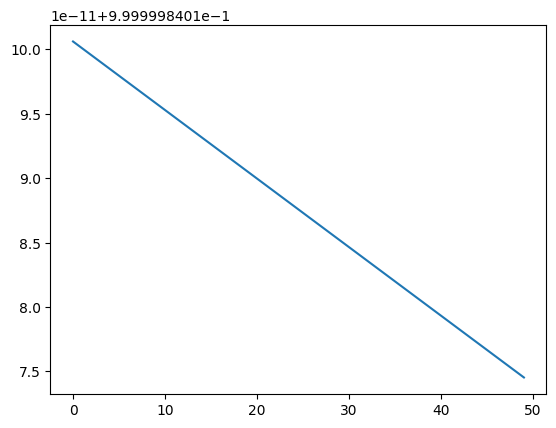

In [80]:
plt.plot(losses)

In [81]:
losses[0]

0.9999998402006092

In [82]:
losses[-1]

0.9999998401745257

# Sample random losses

In [85]:
losses = list()

for i in range(10**3):
    U1 = unitary_sampler.rvs()
    U2 = unitary_sampler.rvs()

    losses.append(loss(U1,U2))

(array([  1.,   2.,   3.,   5.,  14.,  18.,  30.,  50.,  96., 781.]),
 array([0.99991635, 0.99992471, 0.99993308, 0.99994144, 0.99994981,
        0.99995817, 0.99996654, 0.9999749 , 0.99998327, 0.99999163,
        1.        ]),
 <BarContainer object of 10 artists>)

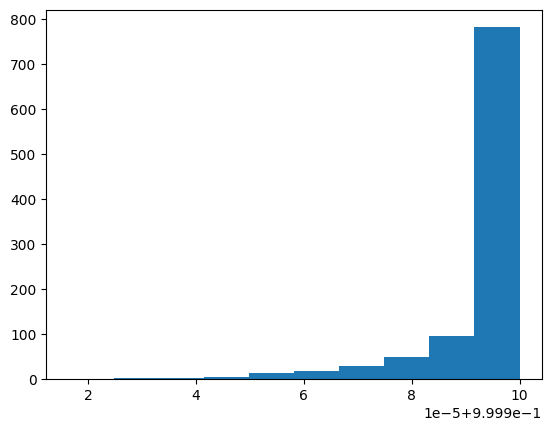

In [86]:
plt.hist(losses)

In [91]:
min_losses = list()

for i in range(10**3):
    min_loss = np.min(np.random.choice(losses, 200))
    min_losses.append(min_loss)

(array([187.,   0., 140., 119., 171.,  83., 121.,  68.,  97.,  14.]),
 array([0.99991635, 0.99992086, 0.99992536, 0.99992987, 0.99993438,
        0.99993888, 0.99994339, 0.9999479 , 0.9999524 , 0.99995691,
        0.99996142]),
 <BarContainer object of 10 artists>)

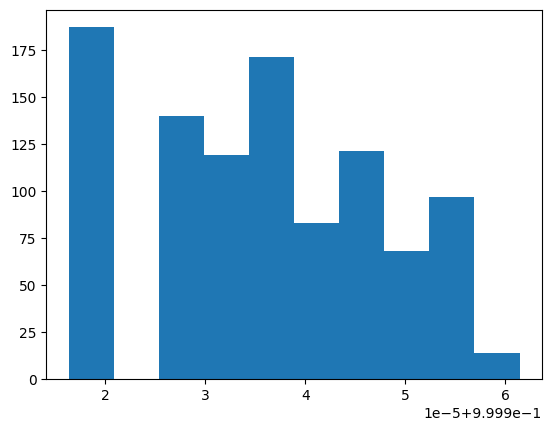

In [92]:
plt.hist(min_losses)

In [93]:
np.max(min_losses)

0.9999614169368163